# Entangling Two Qubits with Error Correction

The screening task of my choice concerns preparing the Bell State $|00\rangle+|11\rangle$ in the way it tolerates single bit-flip and phase-flip errors. It had four subtasks which are addressed in the consecutive subsections below, preceded by introduction of some basic concepts used later in this notebook.

### 0. Intro to bit- and phase-flips

For a general qubit represented in the computational basis as $\alpha |0\rangle + \beta |1\rangle$, basing on <a href="https://en.wikipedia.org/wiki/Quantum_error_correction#The_bit_flip_code">the recommended Wikipedia article</a> a bit flip error occurs when it becomes $\beta |0\rangle + \alpha |1\rangle$ which is equivalent to applying $X$ gate, while a phase flip error occurs when it becomes $\alpha |0\rangle - \beta |1\rangle$ which is equivalent to applying $Z$ gate. To detect and fix single errors of these types one can encode a logical qubit in three physical qubits such that $\alpha |0\rangle + \beta |1\rangle$ becomes $\alpha |000\rangle + \beta |111\rangle$. Then it is possible to perform one of two relevant error correction codes. Namely:

__Bit-flip code__

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Quantum_error_correction_of_bit_flip_using_three_qubits.svg/1920px-Quantum_error_correction_of_bit_flip_using_three_qubits.svg.png" width=600 title="bit"/>

__Phase-flip code__

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Quantum_error_correction_of_phase_flip_using_three_qubits.svg/1920px-Quantum_error_correction_of_phase_flip_using_three_qubits.svg.png" width=750 title="bit"/>

In both cases the first wire carries the original qubit and two other are initialized to zeros and are used for error correction purposes only. The two $CNOT$ gates in the very beginning realize the mentioned encoding $\alpha |0\rangle + \beta |1\rangle$ into $\alpha |000\rangle + \beta |111\rangle$.

### 1. A simple circuit preparing the Bell state

OK, first things first.

In [1]:
import numpy as np
from qiskit import *

qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(0)
qc.cx(0,1)
qc.draw()

┌───┐     
q0_0: ┤ H ├──■──
      └───┘┌─┴─┐
q0_1: ─────┤ X ├
           └───┘

A quick control check by visualizing the produced state on a sphere:

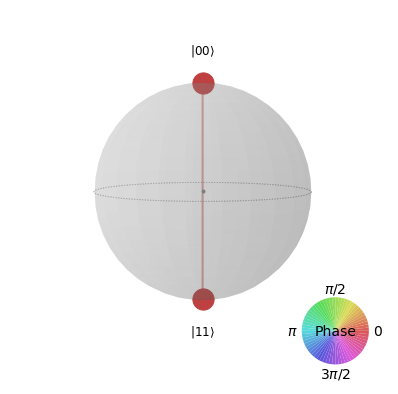

In [2]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
state = Statevector.from_instruction(qc)
plot_state_qsphere(state)

The resulting state is indeed $\frac{1}{\sqrt{2}}\big(|00\rangle+|11\rangle\big)$.

### 2. Adding errors to the circuit
_Now add, right before the $CNOT$ gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a $1$ qubit unitary which can be either the identity, or the $X$ gate (bit-flip error) or the $Z$ gate (phase-flip error)._

Let chances of bit-flip, phase-flip and no error be equal:

In [3]:
p = 0.33 # probability of a bit-flip
q = 0.33 # probability of a phase-flip

Now let's define an error gate as a function that appends one of $X$, $Z$, $I$ to a given circuit with mentioned probabilities.

In [4]:
def errorgate(qcirc, k):
    # qcirc is a given quantum circuit
    # the error gate is applied to the k-th qubit of the circuit
    r = np.random.rand()
    if(r<p):     qcirc.x(k)
    elif(r<p+q): qcirc.z(k)
    else:        qcirc.i(k)

Now the circuit producing the Bell state can be modified in the desired way.

In [5]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(0)

r = np.random.rand()    #adding random error gate
errorgate(qc,0)

r = np.random.rand()    #adding random error gate
errorgate(qc,1)

qc.cx(0,1)
qc.draw()

┌───┐┌───┐     
q1_0: ┤ H ├┤ Z ├──■──
      ├───┤└───┘┌─┴─┐
q1_1: ┤ X ├─────┤ X ├
      └───┘     └───┘

Another quick control check:

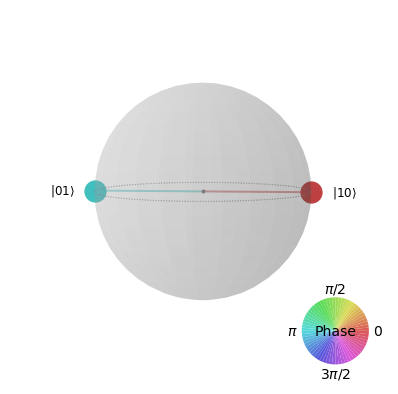

In [6]:
state = Statevector.from_instruction(qc)
plot_state_qsphere(state)

The resulting state in this case is not $\frac{1}{\sqrt{2}}\big(|00\rangle+|11\rangle\big)$.

### 3. Fault-tolerant encoding
_Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!_

Firstly, let's consider all possible effects of error gates in our circuit. Before they are applied, the first qubit is in the following state:
<br><br>
<center> $H|0\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1\\1 & -1\end{bmatrix}\begin{bmatrix}1\\0\end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix}1\\1\end{bmatrix} = |+\rangle$ 
</center>
<br>
A bit-flip error doesn't change the state:
<center> $X|+\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}\begin{bmatrix}1\\1\end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix}1\\1\end{bmatrix} = |+\rangle$ 
</center>
<br>
A phase-flip error does change the state:
<center> $Z|+\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}\begin{bmatrix}1\\1\end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix}1\\-1\end{bmatrix} = |-\rangle$ 
</center>
<br>
Whereas the second qubit is in the state $|0\rangle$ before the error gate is applied, hence a bit-flip error does change it, but a phase-flip error doesn't:
<br><br>
<center> $X|0\rangle = \begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}\begin{bmatrix}1\\0\end{bmatrix} = \begin{bmatrix}0\\1\end{bmatrix} = |1\rangle$ 
</center>
<br>
<center> $Z|0\rangle = \begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}\begin{bmatrix}1\\0\end{bmatrix} = \begin{bmatrix}1\\0\end{bmatrix} = |0\rangle$ 
</center>

Thus, to the first qubit it is enough to apply the phase-flip code only and to the second qubit the bit-flip code only. This way all possible errors happening between $H$ and $CNOT$ will be detected and fixed. The resulting circuit will have $6$ physical qubits in total, out of which $3$ first ones correspond to the first logical qubit and $3$ further correspond to the second logical qubit. Because of the restriction that errors occur only in terms of logical qubits, not physical ones, I assume hereby that errors occur only on the first and the fourth wires, as the rest of wires are just for correcting purposes. 

Below is the implementation realized with a function in order to easily iterate it later while making more measurements. This way the error gates will be randomly chosen each time independently.

In [7]:
def qc_with_error_correction():

    qr2 = QuantumRegister(6)
    cr2 = ClassicalRegister(2)
    qc2 = QuantumCircuit(qr2,cr2)

    qc2.h(0)          #hadamard gate from the original circuit

    qc2.cx(0,1)       #phase-flip code for the first logical qubit
    qc2.cx(0,2)
    qc2.h(0)
    errorgate(qc2,0)
    qc2.h(0)
    qc2.cx(0,1)
    qc2.cx(0,2)
    qc2.ccx(2,1,0)

    qc2.cx(3,4)       #bit-flip code for the second logical qubit
    qc2.cx(3,5)
    errorgate(qc2,3)
    qc2.cx(3,4)
    qc2.cx(3,5)
    qc2.ccx(5,4,3)

    qc2.cx(0,3)       #cnot gate from the original circuit
    
    return qc2

Let's see what does it look like.

In [8]:
qcwer = qc_with_error_correction()
qcwer.draw()

┌───┐          ┌───┐┌───┐┌───┐          ┌───┐     
q2_0: ┤ H ├──■────■──┤ H ├┤ I ├┤ H ├──■────■──┤ X ├──■──
      └───┘┌─┴─┐  │  └───┘└───┘└───┘┌─┴─┐  │  └─┬─┘  │  
q2_1: ─────┤ X ├──┼─────────────────┤ X ├──┼────■────┼──
           └───┘┌─┴─┐               └───┘┌─┴─┐  │    │  
q2_2: ──────────┤ X ├────────────────────┤ X ├──■────┼──
                ├───┤          ┌───┐     └───┘     ┌─┴─┐
q2_3: ──■────■──┤ Z ├──■────■──┤ X ├───────────────┤ X ├
      ┌─┴─┐  │  └───┘┌─┴─┐  │  └─┬─┘               └───┘
q2_4: ┤ X ├──┼───────┤ X ├──┼────■──────────────────────
      └───┘┌─┴─┐     └───┘┌─┴─┐  │                      
q2_5: ─────┤ X ├──────────┤ X ├──■──────────────────────
           └───┘          └───┘                         
c0: 2/══════════════════════════════════════════════════

I waited for the $Z$ and $X$ generation intentionally since then both qubits have to be corrected, so it's the best situation to check does the correction algorithm work.

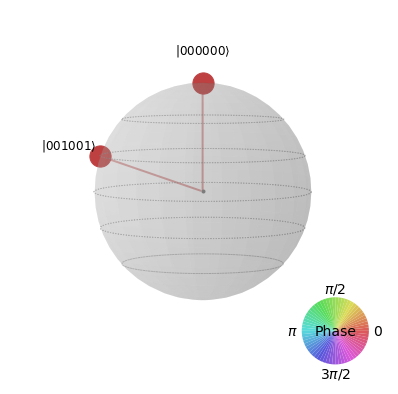

In [9]:
state = Statevector.from_instruction(qcwer)
plot_state_qsphere(state)

As we can see the state is still $\frac{1}{\sqrt{2}}\big(|00\rangle+|11\rangle\big)$ (the first and fourth digits from the right), even though both types of possible flips occured. Success. Of course the visualization of states on the sphere along with their amplitudes and phases is just a convenience offered by theoretical reasoning. In practice, what we get are the probabilities of respective states, so let's simulate our circuit with a qasm simulator.

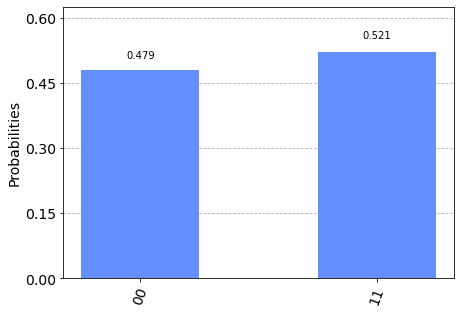

In [10]:
from qiskit.visualization import plot_histogram
qcwer.measure(0,0)
qcwer.measure(3,1)
sim = Aer.get_backend('qasm_simulator')
result = execute(qcwer, sim).result()
counts = result.get_counts()
plot_histogram(counts)

As expected, the probabilities of $00$ and $11$ are pretty similar.

### 4. Fault-tolerant encoding
_Test your solution by making many measurements over the final state and testing that the results are in line with the expectations._

Now for testing the solution not only in the case that was generated above, but in 10000 randomly generated error gates. Just to be sure everything is OK.

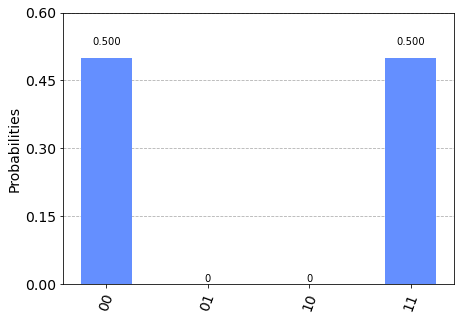

In [11]:
avg_counts = {'00': 0, '01': 0, '10': 0, '11': 0}
for i in range(10000):
    qcwer = qc_with_error_correction()
    qcwer.measure(0,0)
    qcwer.measure(3,1)
    result = execute(qcwer, sim).result()
    counts = result.get_counts()
    for i in counts.keys():
        avg_counts[i] += counts[i]/10000
plot_histogram(avg_counts)

That's it.

### 5. What if errors can happen on all physical qubits?

While doing the above steps I had an overwhelming impression it is so unreal to assume only logical qubits can get flipped. I guess during an experiment all six qubits are supposed to be flipped with equal probability if they are transmitted in the same environment. Of course then we cannot be sure about correcting all the errors, but just out of curiosity I wanted to see in how bad situation we are if we add error gates for all six physical qubits.

Adding four other error gates to the circuit made earlier:

In [12]:
def qc_with_error_correction_bonus():

    qr3 = QuantumRegister(6)
    cr3 = ClassicalRegister(2)
    qc3 = QuantumCircuit(qr3,cr3)

    qc3.h(0)          #hadamard gate from the original circuit

    qc3.cx(0,1)       #phase-flip code for the first logical qubit
    qc3.cx(0,2)
    qc3.h(0)
    qc3.h(1)
    qc3.h(2)
    errorgate(qc3,0)
    errorgate(qc3,1)
    errorgate(qc3,2)
    qc3.h(0)
    qc3.h(1)
    qc3.h(2)
    qc3.cx(0,1)
    qc3.cx(0,2)
    qc3.ccx(2,1,0)

    qc3.cx(3,4)       #bit-flip code for the second logical qubit
    qc3.cx(3,5)
    errorgate(qc3,3)
    errorgate(qc3,4)
    errorgate(qc3,5)
    qc3.cx(3,4)
    qc3.cx(3,5)
    qc3.ccx(5,4,3)

    qc3.cx(0,3)       #cnot gate from the original circuit
    
    return qc3

In [13]:
qcbonus = qc_with_error_correction_bonus()
qcbonus.draw()

┌───┐          ┌───┐┌───┐┌───┐          ┌───┐     
q66656_0: ┤ H ├──■────■──┤ H ├┤ I ├┤ H ├──■────■──┤ X ├──■──
          └───┘┌─┴─┐  │  ├───┤├───┤├───┤┌─┴─┐  │  └─┬─┘  │  
q66656_1: ─────┤ X ├──┼──┤ H ├┤ X ├┤ H ├┤ X ├──┼────■────┼──
               └───┘┌─┴─┐├───┤├───┤├───┤└───┘┌─┴─┐  │    │  
q66656_2: ──────────┤ X ├┤ H ├┤ Z ├┤ H ├─────┤ X ├──■────┼──
                    ├───┤└───┘└───┘├───┤     └───┘     ┌─┴─┐
q66656_3: ──■────■──┤ X ├──■────■──┤ X ├───────────────┤ X ├
          ┌─┴─┐  │  ├───┤┌─┴─┐  │  └─┬─┘               └───┘
q66656_4: ┤ X ├──┼──┤ I ├┤ X ├──┼────■──────────────────────
          └───┘┌─┴─┐├───┤└───┘┌─┴─┐  │                      
q66656_5: ─────┤ X ├┤ I ├─────┤ X ├──■──────────────────────
               └───┘└───┘     └───┘                         
c10001: 2/══════════════════════════════════════════════════

Getting results:

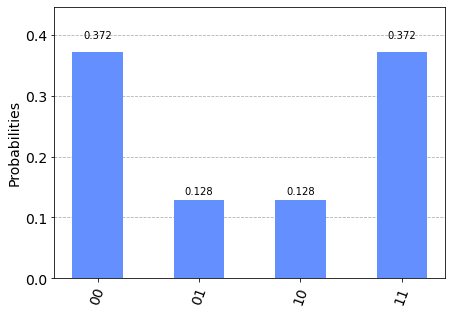

In [14]:
avg_counts = {'00': 0, '01': 0, '10': 0, '11': 0}
for i in range(10000):
    qcbonus = qc_with_error_correction_bonus()
    qcbonus.measure(0,0)
    qcbonus.measure(3,1)
    sim = Aer.get_backend('qasm_simulator')
    result = execute(qcbonus, sim).result()
    counts = result.get_counts()
    for i in counts.keys():
        avg_counts[i] += counts[i]/10000
plot_histogram(avg_counts)

Because of equal probabilities of $|00\rangle$ and $|11\rangle$ as well as $|01\rangle$ and $|10\rangle$, one can suspect the only states that occured are $|00\rangle+|11\rangle$ and $|01\rangle+|10\rangle$. To check this hypothesis let's make some more measurements.

In [15]:
auxiliary_dict0 = {'00': 0, '11': 0}
auxiliary_dict1 = {'01': 0, '10': 0}
a = auxiliary_dict0.keys()
b = auxiliary_dict1.keys()

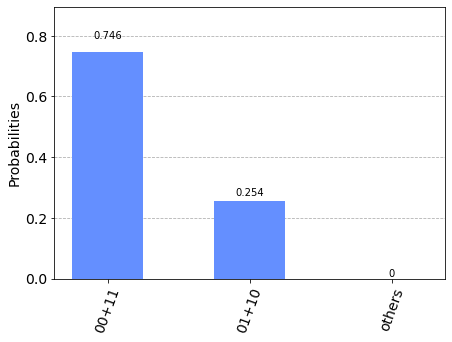

In [16]:
avg_counts = {'00+11': 0, '01+10': 0, 'others': 0}       #we're going to count occurings of respective Bell states 
for i in range(10000):
    qcbonus = qc_with_error_correction_bonus()
    qcbonus.measure(0,0)
    qcbonus.measure(3,1)
    sim = Aer.get_backend('qasm_simulator')
    result = execute(qcbonus, sim).result()
    counts = result.get_counts()
    if (counts.keys() == a): avg_counts['00+11'] += 1     #if the state is 00+11 increase the relevant value in avg_counts
    elif (counts.keys() == b): avg_counts['01+10'] += 1   #if the state is 01+01 increase the relevant value in avg_counts
    else: avg_counts['others'] += 1                       #if the state isn't one of them increase "others" counter
plot_histogram(avg_counts)

Looks like the implemented correction code still works in most cases.